*Efficient Deep learning training*

#

## 

These days models and datasets are becoming **larger** and **larger** and it is becoming increasingly important to increase the efficiency of the training procedure by optimizing memory utilization, speeding up the training, or both.

In this work shop we will cover several techniques that could **speed up** the training of the model and even sometimes make the training **feasible**:
* Batch size optimization
* Automated mixed precision
* Gradient accumulation
* Gradient checkpointing
* Model compilation (for `torch>=2.0`)

## Preparatory stuff

Loading stuff and defining helper functions

In [ ]:
import time
from tqdm import trange

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torchvision.models import get_model

In [ ]:
def print_memory_stats():
    print(f"CUDA max memory allocated: {torch.cuda.max_memory_allocated() / 2 ** 30:.2f} GB.")
    print(f"CUDA max memory reserved: {torch.cuda.max_memory_reserved() / 2 ** 30:.2f} GB.")

Make sure that you are using CUDA Runtime!

In [ ]:
device = "cuda"

Since we have not started using GPU the cell below should output 0.

In [ ]:
print_memory_stats()

CUDA max memory allocated: 0.00 GB.
CUDA max memory reserved: 0.00 GB.


In the following next sections we'll illustrate the techiques on a model from the `torchvision` library. We will adopt `SwinTransformer-Base` for the demonstrations below.

In [ ]:
model = get_model("swin_b").to(device) # it is randomly initialized, but we do not care

In [ ]:
print(f"Number of paramerers: {sum(param.numel() for param in model.parameters()) / 10 ** 6 :.2f} M")

Number of paramerers: 87.77 M


Memory footprint should be roughly `4 * num_model_parameters` since by default we are working in single precision `float32`.

In [ ]:
print_memory_stats()

CUDA max memory allocated: 0.33 GB.
CUDA max memory reserved: 0.36 GB.


Define a function that yields dummy inputs and targets.

In [ ]:
def make_dummy_dataloader(batch_size: int, img_size: int = 224):
  while True:
    yield torch.randn(batch_size, 3, img_size, img_size), torch.randint(low=0, high=1000, size=(batch_size,))

Baseline training loop.

In [ ]:
def train(model, loader, optimizer, loss_fn, num_steps):
  samples_processed = 0
  start = time.perf_counter()
  for i in trange(num_steps, total=num_steps, desc="Train"):
    inputs, targets = next(loader)
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    samples_processed += len(inputs)
  end = time.perf_counter()
  samples_per_sec = samples_processed / (end - start)
  print("\n")
  print_memory_stats()
  print(f"samples/sec: {samples_per_sec:.2f}")
  results = {
      "samples/sec": samples_per_sec,
      "max_memory_allocated": torch.cuda.max_memory_allocated() / 2 ** 30
  }
  return results

## Batch size optimization



Maximizing the throughput (samples/second) leads to lower training cost.
This is generally achieved by utilizing the GPU as much as possible and thus filling GPU memory to its limit.

Below we will show the dependence of the model throughput on the batch size.

In [ ]:
training_steps = 100

In [ ]:
results_for_batch_size = {}
for batch_size in (1, 2, 4, 8, 16, 32, 64, 128):
  print("-" * 10)
  print(f"Batch size: {batch_size}")
  # prepare dataloader
  dataloader = make_dummy_dataloader(batch_size)
  # prepare optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  # train
  try:
    results_for_batch_size[batch_size] = train(model, dataloader, optimizer, F.cross_entropy, training_steps)
  except:
    print("\nCUDA out of memory!")
    print_memory_stats()
    del optimizer
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    break
  del optimizer
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

----------
Batch size: 1


Train: 100%|██████████| 100/100 [00:12<00:00,  7.71it/s]




CUDA max memory allocated: 1.67 GB.
CUDA max memory reserved: 1.78 GB.
samples/sec: 7.71
----------
Batch size: 2


Train: 100%|██████████| 100/100 [00:10<00:00,  9.18it/s]




CUDA max memory allocated: 1.68 GB.
CUDA max memory reserved: 1.86 GB.
samples/sec: 18.34
----------
Batch size: 4


Train: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]




CUDA max memory allocated: 2.34 GB.
CUDA max memory reserved: 2.59 GB.
samples/sec: 24.78
----------
Batch size: 8


Train: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]




CUDA max memory allocated: 2.78 GB.
CUDA max memory reserved: 3.11 GB.
samples/sec: 27.67
----------
Batch size: 16


Train: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]




CUDA max memory allocated: 4.43 GB.
CUDA max memory reserved: 4.89 GB.
samples/sec: 28.54
----------
Batch size: 32


Train: 100%|██████████| 100/100 [01:46<00:00,  1.06s/it]




CUDA max memory allocated: 7.88 GB.
CUDA max memory reserved: 8.65 GB.
samples/sec: 30.11
----------
Batch size: 64


Train:   1%|          | 1/100 [00:03<05:09,  3.13s/it]


CUDA out of memory!
CUDA max memory allocated: 14.00 GB.
CUDA max memory reserved: 14.58 GB.


Let us plot `samples/sec` and `max memory` vs `batch size`.

In [ ]:
batch_sizes = []
samples_sec_per_batch_size = []
max_memory_per_batch_size = []
for k, v in results_for_batch_size.items():
  batch_sizes.append(k)
  samples_sec_per_batch_size.append(v['samples/sec'])
  max_memory_per_batch_size.append(v['max_memory_allocated'])

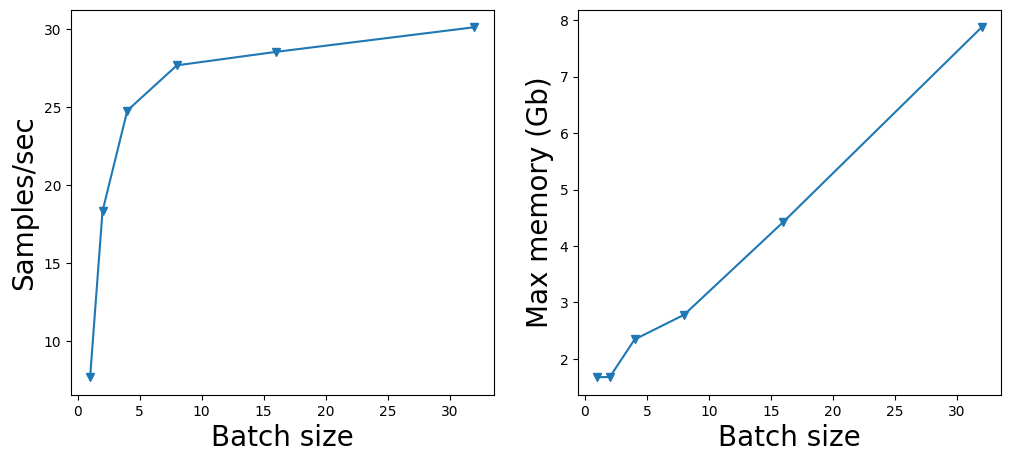

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(batch_sizes, samples_sec_per_batch_size, '-v');
ax[0].set_xlabel("Batch size", fontsize=20);
ax[0].set_ylabel("Samples/sec", fontsize=20);

ax[1].plot(batch_sizes, max_memory_per_batch_size, '-v');
ax[1].set_xlabel("Batch size", fontsize=20);
ax[1].set_ylabel("Max memory (Gb)", fontsize=20);

**Note!**

Batch size (together with learning rate) determine the degree of stochasticity of gradient descent.

Often, a certain magnitude of noise in optimization trajectory is crucial for finding well generalizing solutions.

Therefore, the batch size has to be chosen wisely 🤔.



## Automated mixed precision

Machines work with number in finite precision. Different formats are defined in [IEEE754](https://en.wikipedia.org/wiki/IEEE_754).

Unlike some other applications, such as physics and engineering neural networks are more robust to numerical errors and up to a certain point one reduce precision without impact on performance.

Lower precision offers faster operations with numbers and reduced memory usage.

Below we'll illustrate some commonly used formats.

**FP32** (default in PyTorch)

This format was the workhorse of deep learning for a long time.

* 1 bit sign
* 8 bits exponent
* 23 bits fraction (aka mantissa)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Float_example.svg/1180px-Float_example.svg.png" width="600" alt="Deep Recurrent Neural Networks">

Range: ~1.18e-38 … ~3.40e38 with 6-9 significant decimal digits precision.

**FP16**

Arguably, the most popular format for large model training and inference:

* 1 bit sign
* 5 bits exponent
* 10 bits fraction

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/IEEE_754r_Half_Floating_Point_Format.svg/350px-IEEE_754r_Half_Floating_Point_Format.svg.png" width="300" alt="Deep Recurrent Neural Networks">

Range: ~5.96e−8 (6.10e−5) … 65504 with 4 significant decimal digits precision.

**BF16**

Brain Float format developed by Google. Has higher dynamical range compared to FP16, but lower precision.

* 1 bit sign
* 8 bits exponent
* 7 bits fraction

Range: ~5.96e−8 (6.10e−5) … 65504 with 4 significant decimal digits precision.

<img src="https://miro.medium.com/v2/resize:fit:520/format:webp/0*m4rcg4_23-1qQ_kp.png" width="300" alt="Deep Recurrent Neural Networks">


Range: ~1.18e-38 … ~3.40e38 with 3 significant decimal digits.

**Note**

This format is supported only for NVIDIA architectures from Ampere and newer (A100, RTX30`**`, RTX40`**`). Older GPUs, such as fellow T4, do not have hardware support for it.

For more details on numerical formats I recommend [this blog](https://moocaholic.medium.com/fp64-fp32-fp16-bfloat16-tf32-and-other-members-of-the-zoo-a1ca7897d407).

**Automated mixed precision** runs some operations `(nn.Linear, nn.Conv*d)` in `fp16` , whereas other operations that are more vulnerable to numerical approximations are run in higher precision `fp32`. Gradients w/r to model parameters and optimizer stats are typically kept in `fp32`. Parameter updates act on `fp32` copy of the model.


In [ ]:
def train(model, loader, optimizer, scaler, loss_fn, num_steps):
  """
  Args:
    model - model trained
    loader - data loader
    optimizer - optimizer
    scaler - gradient scaler that shifts the gradient range
    loss_fn - task loss function
    num_steps.- number of training steps
  Returns:
    dict with performance stats
  """
  samples_processed = 0
  start = time.perf_counter()
  for i in trange(num_steps, total=num_steps, desc="Train"):
    inputs, targets = next(loader)
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
    assert not loss.isnan(), "Loss is NaN. Terminating training."
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
    samples_processed += len(inputs)
  end = time.perf_counter()
  samples_per_sec = samples_processed / (end - start)
  print("\n")
  print_memory_stats()
  print(f"samples/sec: {samples_per_sec:.2f}")
  results = {
      "samples/sec": samples_per_sec,
      "max_memory_allocated": torch.cuda.max_memory_allocated() / 2 ** 30
  }
  return results

In [ ]:
results_for_batch_size_amp = {}
for batch_size in (1, 2, 4, 8, 16, 32, 64, 128):
  print("-" * 10)
  print(f"Batch size: {batch_size}")
  # prepare dataloader
  dataloader = make_dummy_dataloader(batch_size)
  # prepare optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  # prepare scaler
  scaler = GradScaler()
  # train
  try:
    results_for_batch_size_amp[batch_size] = train(model, dataloader, optimizer, scaler, F.cross_entropy, training_steps)
  except:
    print("\nCUDA out of memory!")
    print_memory_stats()
    del optimizer
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    break
  del optimizer
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

----------
Batch size: 1


Train: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]




CUDA max memory allocated: 1.67 GB.
CUDA max memory reserved: 1.82 GB.
samples/sec: 11.22
----------
Batch size: 2


Train: 100%|██████████| 100/100 [00:09<00:00, 10.05it/s]




CUDA max memory allocated: 1.68 GB.
CUDA max memory reserved: 1.84 GB.
samples/sec: 20.10
----------
Batch size: 4


Train: 100%|██████████| 100/100 [00:09<00:00, 10.48it/s]




CUDA max memory allocated: 1.73 GB.
CUDA max memory reserved: 1.91 GB.
samples/sec: 41.89
----------
Batch size: 8


Train: 100%|██████████| 100/100 [00:11<00:00,  8.94it/s]




CUDA max memory allocated: 2.31 GB.
CUDA max memory reserved: 2.52 GB.
samples/sec: 71.42
----------
Batch size: 16


Train: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]




CUDA max memory allocated: 3.42 GB.
CUDA max memory reserved: 3.88 GB.
samples/sec: 86.95
----------
Batch size: 32


Train: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]




CUDA max memory allocated: 5.82 GB.
CUDA max memory reserved: 6.44 GB.
samples/sec: 94.02
----------
Batch size: 64


Train: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]




CUDA max memory allocated: 10.66 GB.
CUDA max memory reserved: 11.57 GB.
samples/sec: 95.90
----------
Batch size: 128


Train:   0%|          | 0/100 [00:00<?, ?it/s]


CUDA out of memory!
CUDA max memory allocated: 1.61 GB.


CUDA max memory reserved: 2.44 GB.


In [ ]:
batch_sizes_amp = []
samples_sec_per_batch_size_amp = []
max_memory_per_batch_size_amp = []
for k, v in results_for_batch_size_amp.items():
  batch_sizes_amp.append(k)
  samples_sec_per_batch_size_amp.append(v['samples/sec'])
  max_memory_per_batch_size_amp.append(v['max_memory_allocated'])

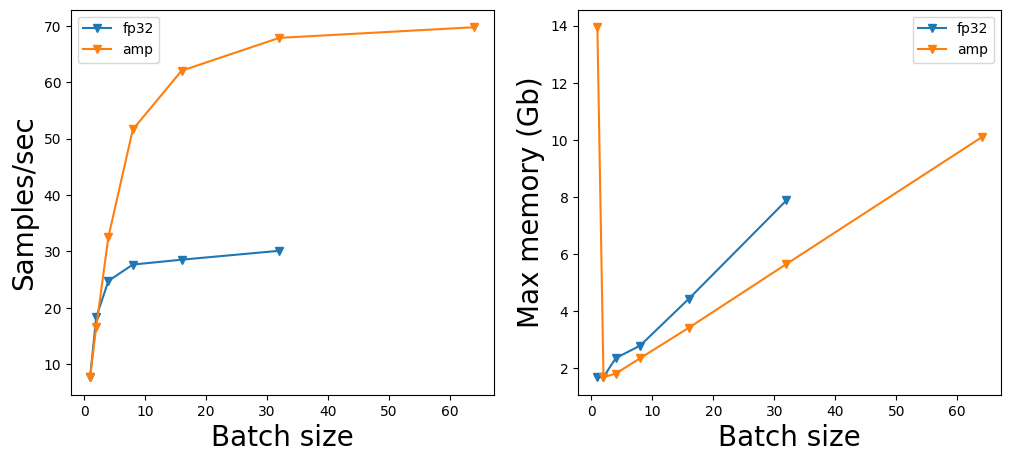

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(batch_sizes, samples_sec_per_batch_size, '-v', label='fp32');
ax[0].plot(batch_sizes_amp, samples_sec_per_batch_size_amp, '-v', label='amp');
ax[0].set_xlabel("Batch size", fontsize=20);
ax[0].set_ylabel("Samples/sec", fontsize=20);
ax[0].legend();

ax[1].plot(batch_sizes, max_memory_per_batch_size, '-v', label='fp32');
ax[1].plot(batch_sizes_amp, max_memory_per_batch_size_amp, '-v', label='amp');
ax[1].set_xlabel("Batch size", fontsize=20);
ax[1].set_ylabel("Max memory (Gb)", fontsize=20);
ax[1].legend();

In [ ]:
print(f"Speedup: {max(samples_sec_per_batch_size_amp) / max(samples_sec_per_batch_size):.2f}x")

Speedup: 2.32x


With **amp** we have accelerated training by more than 2x!

Largest batch size that fits onto the memory of device has almost doubled as well.

### Grad scaler

In the example above we've observed some mysterious entity called GradScaler. Why do we need it?

Note, that `fp16` has much narrower range of representable values compared to `fp32`.

<img src="https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/_images/loss_scaling.png" alt="Deep Recurrent Neural Networks">

If the values inside a tensor are too small or to large they may not fit inside `fp16`, that may lead to divergence, especially if training large models for a long time.

<img src="https://docscontent.nvidia.com/dims4/default/d785744/2147483647/strip/true/crop/707x421+0+0/resize/1414x842!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fdita%2F00000189-949d-d46e-abe9-bcdf9f8c0000%2Fdeeplearning%2Fperformance%2Fmixed-precision-training%2Fgraphics%2Ftraining-iteration.png" width="550" alt="Deep Recurrent Neural Networks">

`GradScaler` tracks the magnitude of the loss, builds historgram of gradients and shifts it towards the range that is well represented by the fp16 numerical format.

Let us illustrate the problem on a toy example below.

In [ ]:
W = torch.randn(8192, 8192, device=device, dtype=torch.float16, requires_grad=True)
X = torch.randn(8, 8192, device=device, dtype=torch.float16)
Y = torch.randn(8, 8192, device=device, dtype=torch.float16)

In [ ]:
loss = F.mse_loss(X @ W.T, Y)

In [ ]:
loss

tensor(inf, device='cuda:0', dtype=torch.float16, grad_fn=<MseLossBackward0>)

Indeed this example is arfiticial, as one would init weights $w_{ij} \in \mathcal{N}(0, \frac{1}{d})$ but shows the point.

In [ ]:
del W, X, Y, loss
torch.cuda.empty_cache()

**Materials for further study.**

* [PyTorch amp examples](https://pytorch.org/docs/stable/notes/amp_examples.html)

* [Great blog about amp by NVIDIA](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html)

* [A page about fp8 format in Transformer engine](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/examples/fp8_primer.html)

## Gradient accumulation

Commonly, a researcher or a practioner follows standard training recipes from papers. However, it is often the case that hardware doesn't allow to train on the large batches that are affordable for Google and OpenAI guys.

In principle, one can fit 'almost' arbitrary large batch size via gradient checkpointing illustrated below.

The idea behind gradient accumulation is to instead of calculating the gradients for the whole batch at once to do it in smaller steps. The way we do that is to calculate the gradients iteratively in smaller batches by doing a forward and backward pass through the model and accumulating the gradients in the process. When enough gradients are accumulated we run the model’s optimization step. This way we can easily increase the overall batch size to numbers that would never fit into the GPU’s memory. In turn, however, the added forward and backward passes can slow down the training a bit.

In [ ]:
def train(model, loader, optimizer, scaler, loss_fn, num_steps, grad_accum_steps=1):
  """
  Args:
    model - model trained
    loader - data loader
    optimizer - optimizer
    scaler - gradient scaler that shifts the gradient range
    loss_fn - task loss function
    num_steps - number of training steps
    grad_accum_steps - number of gradient accumulation steps
  Returns:
    dict with performance stats
  """
  samples_processed = 0
  start = time.perf_counter()
  for i in trange(num_steps, total=num_steps, desc="Train"):
    inputs, targets = next(loader)
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
    assert not loss.isnan(), "Loss is NaN. Terminating training."
    scaler.scale(loss / grad_accum_steps).backward()
    if (i + 1) % grad_accum_steps == 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
    samples_processed += len(inputs)
  end = time.perf_counter()
  samples_per_sec = samples_processed / (end - start)
  print("\n")
  print_memory_stats()
  print(f"samples/sec: {samples_per_sec:.2f}")
  results = {
      "samples/sec": samples_per_sec,
      "max_memory_allocated": torch.cuda.max_memory_allocated() / 2 ** 30
  }
  return results

In the example below largest batch size, that fit into our memory was 64. Let us use it as a `microbatch_size`.

Total batch size is `microbatch_size * grad_accum_steps`.

In [ ]:
results_for_batch_size_grad_accum = {}

microbatch_size = 64
training_steps = 100

for batch_size in (512, 1024, 2048):
  print("-" * 10)
  print(f"Batch size: {batch_size}")
  grad_accum_steps = batch_size // microbatch_size
  # prepare dataloader
  dataloader = make_dummy_dataloader(microbatch_size)
  # prepare optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  # prepare scaler
  scaler = GradScaler()
  # train
  results_for_batch_size_grad_accum[batch_size] = train(
    model, dataloader, optimizer, scaler, F.cross_entropy, training_steps, grad_accum_steps
  )
  del optimizer
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

----------
Batch size: 512


Train: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]




CUDA max memory allocated: 10.56 GB.
CUDA max memory reserved: 10.74 GB.
samples/sec: 76.79
----------
Batch size: 1024


Train: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]




CUDA max memory allocated: 10.56 GB.
CUDA max memory reserved: 10.84 GB.
samples/sec: 77.72
----------
Batch size: 2048


Train: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]




CUDA max memory allocated: 10.56 GB.
CUDA max memory reserved: 10.86 GB.
samples/sec: 78.00


In [ ]:
batch_sizes_grad_accum = []
samples_sec_per_batch_size_grad_accum = []
max_memory_per_batch_size_grad_accum = []
for k, v in results_for_batch_size_grad_accum.items():
  batch_sizes_grad_accum.append(k)
  samples_sec_per_batch_size_grad_accum.append(v['samples/sec'])
  max_memory_per_batch_size_grad_accum.append(v['max_memory_allocated'])

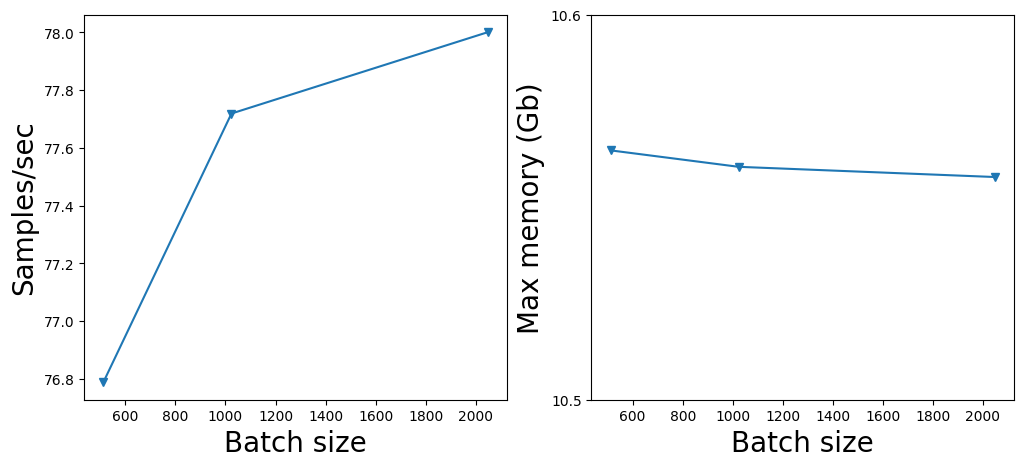

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(batch_sizes_grad_accum, samples_sec_per_batch_size_grad_accum, '-v');
ax[0].set_xlabel("Batch size", fontsize=20);
ax[0].set_ylabel("Samples/sec", fontsize=20);

ax[1].plot(batch_sizes_grad_accum, max_memory_per_batch_size_grad_accum, '-v');
ax[1].set_xlabel("Batch size", fontsize=20);
ax[1].set_ylabel("Max memory (Gb)", fontsize=20);
ax[1].set_yticks([10.5, 10.6]);

One can fit large batch size with gradient checkpointing.

**Note**, however, that it doesn't make the training faster in termps of `samples/sec`.

 ## Gradient checkpointing

 Even when we set the batch size to 1 and use gradient accumulation we can still run out of memory when working with large models. In order to compute the gradients during the backward pass all activations from the forward pass are normally saved. This can create a big memory overhead. Alternatively, one could forget all activations during the forward pass and recompute them on demand during the backward pass.

 This allows one reduce memory footprint at the cost of additional computations.

In [ ]:
from types import MethodType
from torch.utils.checkpoint import checkpoint_sequential

Below we'll adopt the training loop from AMP section

In [ ]:
def train(model, loader, optimizer, scaler, loss_fn, num_steps):
  """
  Args:
    model - model trained
    loader - data loader
    optimizer - optimizer
    scaler - gradient scaler that shifts the gradient range
    loss_fn - task loss function
    num_steps.- number of training steps
  Returns:
    dict with performance stats
  """
  samples_processed = 0
  start = time.perf_counter()
  for i in trange(num_steps, total=num_steps, desc="Train"):
    inputs, targets = next(loader)
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
    assert not loss.isnan(), "Loss is NaN. Terminating training."
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
    samples_processed += len(inputs)
  end = time.perf_counter()
  samples_per_sec = samples_processed / (end - start)
  print("\n")
  print_memory_stats()
  print(f"samples/sec: {samples_per_sec:.2f}")
  results = {
      "samples/sec": samples_per_sec,
      "max_memory_allocated": torch.cuda.max_memory_allocated() / 2 ** 30
  }
  return results

Let us create the model again for the sake of safety

In [ ]:
model = get_model("swin_b").to(device)

In [ ]:
num_segments = len(model.features) # we set checkpoint after every SwinTransformer block

# a hack to change forward pass of a model
def custom_forward(self, x):
    x.requires_grad = True
    x = checkpoint_sequential(model.features, num_segments, x)
    x = self.norm(x)
    x = self.permute(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    x = self.head(x)
    return x

model.forward = MethodType(custom_forward, model)

In [ ]:
results_for_batch_size_grad_ckpt = {}
for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
  print("-" * 10)
  print(f"Batch size: {batch_size}")
  # prepare dataloader
  dataloader = make_dummy_dataloader(batch_size)
  # prepare optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  # prepare scaler
  scaler = GradScaler()
  # train
  try:
    training_steps = min(4096 // batch_size, 100)
    results_for_batch_size_grad_ckpt[batch_size] = train(model, dataloader, optimizer, scaler, F.cross_entropy, training_steps)
  except:
    print("\nCUDA out of memory!")
    print_memory_stats()
    del optimizer
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    break
  del optimizer
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

----------
Batch size: 1


Train:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:542: UserWarning: torch.utils.checkpoint.checkpoint_sequential: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Train: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]




CUDA max memory allocated: 2.14 GB.
CUDA max memory reserved: 2.23 GB.
samples/sec: 6.14
----------
Batch size: 2


Train: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]




CUDA max memory allocated: 2.14 GB.
CUDA max memory reserved: 2.24 GB.
samples/sec: 12.59
----------
Batch size: 4


Train: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]




CUDA max memory allocated: 2.14 GB.
CUDA max memory reserved: 2.30 GB.
samples/sec: 25.27
----------
Batch size: 8


Train: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]




CUDA max memory allocated: 2.38 GB.
CUDA max memory reserved: 2.60 GB.
samples/sec: 39.26
----------
Batch size: 16


Train: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]




CUDA max memory allocated: 3.03 GB.
CUDA max memory reserved: 3.28 GB.
samples/sec: 48.19
----------
Batch size: 32


Train: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]




CUDA max memory allocated: 4.34 GB.
CUDA max memory reserved: 4.69 GB.
samples/sec: 51.15
----------
Batch size: 64


Train: 100%|██████████| 64/64 [01:18<00:00,  1.23s/it]




CUDA max memory allocated: 6.98 GB.
CUDA max memory reserved: 8.12 GB.
samples/sec: 52.18
----------
Batch size: 128


Train: 100%|██████████| 32/32 [01:18<00:00,  2.44s/it]




CUDA max memory allocated: 12.23 GB.
CUDA max memory reserved: 14.29 GB.
samples/sec: 52.44
----------
Batch size: 256


Train:   0%|          | 0/16 [00:02<?, ?it/s]


CUDA out of memory!
CUDA max memory allocated: 14.10 GB.
CUDA max memory reserved: 14.51 GB.


In [ ]:
batch_sizes_grad_ckpt = []
samples_sec_per_batch_size_grad_ckpt = []
max_memory_per_batch_size_grad_ckpt = []
for k, v in results_for_batch_size_grad_ckpt.items():
  batch_sizes_grad_ckpt.append(k)
  samples_sec_per_batch_size_grad_ckpt.append(v['samples/sec'])
  max_memory_per_batch_size_grad_ckpt.append(v['max_memory_allocated'])

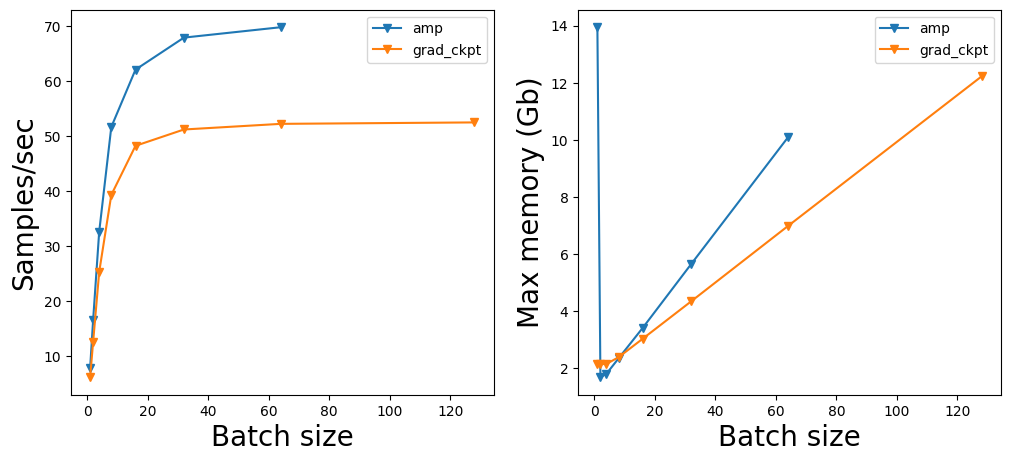

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(batch_sizes_amp, samples_sec_per_batch_size_amp, '-v', label='amp');
ax[0].plot(batch_sizes_grad_ckpt, samples_sec_per_batch_size_grad_ckpt, '-v', label='grad_ckpt');
ax[0].set_xlabel("Batch size", fontsize=20);
ax[0].set_ylabel("Samples/sec", fontsize=20);
ax[0].legend();

ax[1].plot(batch_sizes_amp, max_memory_per_batch_size_amp, '-v', label='amp');
ax[1].plot(batch_sizes_grad_ckpt, max_memory_per_batch_size_grad_ckpt, '-v', label='grad_ckpt');
ax[1].set_xlabel("Batch size", fontsize=20);
ax[1].set_ylabel("Max memory (Gb)", fontsize=20);
ax[1].legend();

**Nice!** 🙀

Now we can fit even larger batch size **128** onto a single `T4` GPU!

Note, that this tecnique doesn't typically accelerate training.

However, in case the model is pretty large (such as modern transformer), and inputs are pretty large (large images or long sequences), `gradient_checkpointing` is very reasonable option to try.

Some frameworks and libraries support `gradient_checkpointing` out of the box:
* `timm` - `set_grad_checkpointing` method in some models
* `transformers` 🤗 - `model.gradient_checkpointing_enable()`

Additional resources:
* [Article on gradient checkpointing](https://medium.com/tensorflow/fitting-larger-networks-into-memory-583e3c758ff9)

## Model compilation

Since `torch > 2.0` users can compile their model prior to running. Compilation can make PyTorch code run faster by JIT-compiling PyTorch code into optimized kernels, all while requiring minimal code changes.

However, note that the compilation takes some time, as the users familiar with compiled languages may remember.

If the run is very short it may be not the best option.

For long enough runtime `torch.compile` offers nontrivial speed-up of training and inference.

Below we will illustrate the benefit of `torch.compile` on RMSNorm, a commonly used normalization layer in modern LLMs.

In [ ]:
class RMSNorm(nn.Module):

    def __init__(self, hidden_size, eps=1e-6):
        """
        RMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)

In [ ]:
# Llama-2-7b sizes
batch_size = 1
sequence_length = 4096
hidden_size = 4096
# benchmark settings
warmup_iters = 1000
benchmark_iters = 1000

In [ ]:
# generate random sequence
inputs = torch.randn(batch_size, sequence_length, hidden_size, device=device, dtype=torch.float16)

Define RMSNorm layer

In [ ]:
rms_norm = RMSNorm(hidden_size).to(device=device, dtype=torch.float16)

In [ ]:
for _ in range(warmup_iters):
  rms_norm(inputs)

times = []
for _ in range(benchmark_iters):
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()
  rms_norm(inputs)
  end.record()
  torch.cuda.synchronize()
  times.append(start.elapsed_time(end))

In [ ]:
print(f"Average latency: {np.mean(times):.3f} ms")

Average latency: 2.627 ms


Let us compile the layer.

In [ ]:
rms_norm = torch.compile(rms_norm)

In [ ]:
for _ in range(warmup_iters):
  rms_norm(inputs)

times = []
for _ in range(benchmark_iters):
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()
  rms_norm(inputs)
  end.record()
  torch.cuda.synchronize()
  times.append(start.elapsed_time(end))

In [ ]:
print(f"Average latency: {np.mean(times):.3f} ms")

Average latency: 0.449 ms


4-5x speedup!

<img src="https://resizing.flixster.com/1Y1Dup_mSJqfq4y-QXTwqbuG45Y=/fit-in/705x460/v2/https://resizing.flixster.com/-XZAfHZM39UwaGJIFWKAE8fS0ak=/v3/t/assets/p2845607_e_h9_ab.jpg" width="300" alt="Deep Recurrent Neural Networks">

In [ ]:
del rms_norm, inputs
torch.cuda.empty_cache()

Now let us apply torch compile to training the model from previous examples.

In [ ]:
def train(model, loader, optimizer, scaler, loss_fn, num_steps, warmup_steps=10):
  """
  Args:
    model - model trained
    loader - data loader
    optimizer - optimizer
    scaler - gradient scaler that shifts the gradient range
    loss_fn - task loss function
    num_steps - number of training steps
    num_steps - number of warmup steps
  Returns:
    dict with performance stats
  """
  samples_processed = 0
  # warmup
  start = time.perf_counter()
  for i in range(warmup_steps):
    inputs, targets = next(loader)
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
    scaler.scale(loss).backward()
    optimizer.zero_grad()
  end = time.perf_counter()
  compile_time = end - start
  print(f"Compilation took {(end - start):.2f}s.")
  # start of training loop
  start = time.perf_counter()
  for i in trange(num_steps , total=num_steps, desc="Train"):
    inputs, targets = next(loader)
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
    assert not loss.isnan(), "Loss is NaN. Terminating training."
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
    samples_processed += len(inputs)
  end = time.perf_counter()
  samples_per_sec = samples_processed / (end - start)
  print("\n")
  print_memory_stats()
  print(f"samples/sec: {samples_per_sec:.2f}")
  results = {
      "samples/sec": samples_per_sec,
      "max_memory_allocated": torch.cuda.max_memory_allocated() / 2 ** 30,
      "compile_time": compile_time
  }
  return results

In [ ]:
model = get_model("swin_b").to(device)

In [ ]:
model = torch.compile(model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
results_for_batch_size_compile = {}
training_steps = 100
warmup_steps = 10

for batch_size in (1, 2, 4, 8, 16, 32, 64):
  print("-" * 10)
  print(f"Batch size: {batch_size}")
  # prepare dataloader
  dataloader = make_dummy_dataloader(batch_size)
  # prepare optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  # prepare scaler
  scaler = GradScaler()
  # train
  try:
    results_for_batch_size_compile[batch_size] = train(model, dataloader, optimizer, scaler, F.cross_entropy, training_steps, warmup_steps)
  except:
    print("\nCUDA out of memory!")
    print_memory_stats()
    del optimizer
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    break
  del optimizer
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

----------
Batch size: 1
Compilation took 110.28s.


Train: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]




CUDA max memory allocated: 1.67 GB.
CUDA max memory reserved: 1.80 GB.
samples/sec: 11.22
----------
Batch size: 2
Compilation took 228.16s.


Train: 100%|██████████| 100/100 [00:10<00:00,  9.47it/s]




CUDA max memory allocated: 1.68 GB.
CUDA max memory reserved: 1.80 GB.
samples/sec: 18.93
----------
Batch size: 4
Compilation took 0.65s.


Train: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]




CUDA max memory allocated: 1.73 GB.
CUDA max memory reserved: 1.91 GB.
samples/sec: 42.42
----------
Batch size: 8
Compilation took 0.79s.


Train: 100%|██████████| 100/100 [00:11<00:00,  8.85it/s]




CUDA max memory allocated: 2.30 GB.
CUDA max memory reserved: 2.50 GB.
samples/sec: 70.78
----------
Batch size: 16
Compilation took 1.45s.


Train: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]




CUDA max memory allocated: 3.42 GB.
CUDA max memory reserved: 3.86 GB.
samples/sec: 86.31
----------
Batch size: 32
Compilation took 2.82s.


Train: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]




CUDA max memory allocated: 5.83 GB.
CUDA max memory reserved: 6.46 GB.
samples/sec: 93.34
----------
Batch size: 64
Compilation took 5.45s.


Train: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]




CUDA max memory allocated: 10.66 GB.
CUDA max memory reserved: 11.63 GB.
samples/sec: 93.77


How long does the compilation take? ⏲

In [ ]:
batch_sizes_compile = []
samples_sec_per_batch_size_compile = []
max_memory_per_batch_size_compile = []
for k, v in results_for_batch_size_compile.items():
  batch_sizes_compile.append(k)
  samples_sec_per_batch_size_compile.append(v['samples/sec'])
  max_memory_per_batch_size_compile.append(v['max_memory_allocated'])

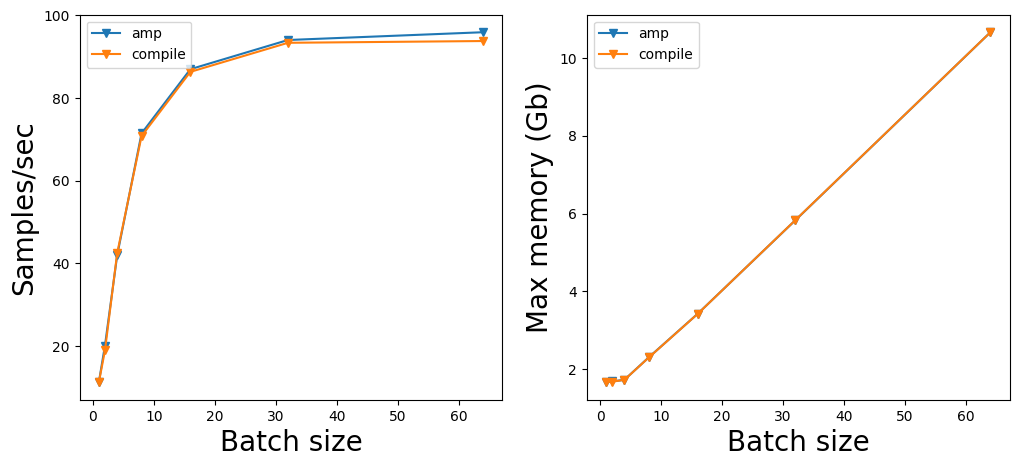

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(batch_sizes_amp, samples_sec_per_batch_size_amp, '-v', label='amp');
ax[0].plot(batch_sizes_compile, samples_sec_per_batch_size_compile, '-v', label='compile');
ax[0].set_xlabel("Batch size", fontsize=20);
ax[0].set_ylabel("Samples/sec", fontsize=20);
ax[0].legend();

ax[1].plot(batch_sizes_amp, max_memory_per_batch_size_amp, '-v', label='amp');
ax[1].plot(batch_sizes_compile, max_memory_per_batch_size_compile, '-v', label='compile');
ax[1].set_xlabel("Batch size", fontsize=20);
ax[1].set_ylabel("Max memory (Gb)", fontsize=20);
ax[1].legend();

Do you observe benefits from compilation?

Additional resources
* [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html)

## Summary and concluding remarks

In the table below we summarize the benefits proposed by each method covered in the seminar.

| Method                   | Speed | Memory |
|--------------------------|-------|--------|
| Batch size               | Yes   | Yes    |
| Mixed precision training | Yes   | Yes*   |
| Gradient accumulation    | No    | Yes    |
| Gradient checkpointing   | No    | Yes    |
| Compilation              | Yes   | No     |

Some notes are worth being mentioned.
* AMP is a great choice for small model, when the model takes small fraction of the system VRAM. However, it requires to store a version of model both in fp16 and fp32 precision and may even increase memory overhead when working with large models.

Additional materials
* [Great overview with examples on Huggingface on efficient training](https://huggingface.co/docs/transformers/v4.20.1/en/perf_train_gpu_one#efficient-training-on-a-single-gpu) 🤗